In [1]:
import json
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import copy

c:\Users\KARAN\AppData\Local\Programs\Orange\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ann_dict = {}

with open('dataset\material_version\instances_train_trashcan.json') as ann:
    ann_dict = json.load(ann)

In [3]:
ann_dict.keys()


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [4]:
len(ann_dict['images'])

6008

In [5]:
pd.__version__
!pip3 install pandas==1.3.5 --user

In [6]:
pd.__version__

'1.3.5'

In [7]:
# compile the relevant data into a pickle file 
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(ann_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(ann_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
data.image_id -= 1
data.to_pickle('UTD_train.pkl', protocol=4)
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,1,vid_000421_frame0000005.jpg,8,"[135.00375939849624, 157.00387596899225, 155.9...",480,360
1,1,2,vid_000106_frame0000015.jpg,2,"[1.0019607843137255, 171.00196078431372, 476.9...",480,360
2,1,3,vid_000106_frame0000015.jpg,4,"[233.00833333333333, 252.0040322580645, 38.986...",480,360
3,1,4,vid_000106_frame0000015.jpg,4,"[270.03125, 246.00342465753425, 39.96199324324...",480,360
4,1,5,vid_000106_frame0000015.jpg,4,"[5.004464285714286, 238.00409836065575, 34.979...",480,360
...,...,...,...,...,...,...,...
9736,6005,9737,vid_000131_frame0000018.jpg,1,"[0.001968503937007874, 256.00409836065575, 59....",480,270
9737,6005,9738,vid_000131_frame0000018.jpg,9,"[167.00434782608696, 207.0108695652174, 70.991...",480,270
9738,6006,9739,vid_000551_frame0000067.jpg,8,"[151.00255102040816, 144.00213675213675, 76.99...",480,270
9739,6006,9740,vid_000551_frame0000067.jpg,4,"[0.00196078431372549, 28.05, 123.9980392156862...",480,270


In [8]:
pd.__version__

'1.3.5'

In [9]:
for box in list(data.bbox.values):
    max_ = max(box)
    idx = box.index(max_)
    if (idx == 2) or (idx == 3):
        print(max_, idx)
        
# xmin, ymin, width, height

186.9908048820716 3
476.99607843137255 2
478.9906168710516 2
256.99607843137255 3
360.99607843137255 3
217.99607843137255 2
221.99607843137255 2
268.97653194263364 2
100.9799339598679 2
479.997619047619 2
475.99607843137255 2
316.993964509251 2
365.99607843137255 2
190.99607843137255 2
423.9794546850998 2
264.99607843137255 2
103.98598191214471 2
440.9937657114128 2
395.9852917665867 2
359.9813725490196 3
451.99428424926106 2
330.99374805840324 2
175.99803921568628 2
256.99607843137255 3
480.99607843137255 2
194.99602308665402 2
225.97866263440864 2
477.99607843137255 2
479.99607843137255 2
256.99607843137255 3
204.974375 2
313.98710317460313 2
223.99607843137255 2
273.99607843137255 2
344.99607843137255 3
194.99603921568627 3
454.99337037037037 2
366.9944888565891 2
334.99607843137255 2
300.99607843137255 2
361.871875 2
480.9932909869954 2
195.9958632478632 3
338.99607843137255 3
223.99607843137255 2
217.9936144369252 2
282.9782021604938 2
268.96824596774195 2
271.7480392156863 2
424.

In [10]:
data.height.unique()

array([360, 270], dtype=int64)

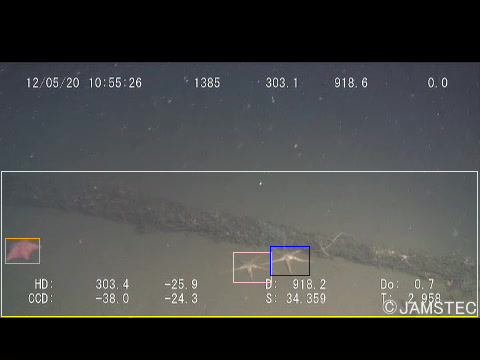

In [11]:
# test out ground truth bounding boxes

# bbox = (xmin, ymin, width, height) !!!

xmin, ymin, width, height = data.iloc[1].bbox
xmax = xmin + width
ymax = ymin + height

xmin2, ymin2, width2, height2 = data.iloc[2].bbox
xmax2 = xmin2 + width2
ymax2 = ymin2 + height2

xmin3, ymin3, width3, height3 = data.iloc[3].bbox
xmax3 = xmin3 + width3
ymax3 = ymin3 + height3

xmin4, ymin4, width4, height4 = data.iloc[4].bbox
xmax4 = xmin4 + width4
ymax4 = ymin4 + height4


test_image = Image.open(r"dataset\material_version\train\vid_000106_frame0000015.jpg")

draw = ImageDraw.Draw(test_image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="yellow") # label is plant
draw.rectangle([(xmin2, ymin2), (xmax2, ymax2)], outline="pink") # label is starfish
draw.rectangle([(xmin3, ymin3), (xmax3, ymax3)], outline="blue") # label is starfish
draw.rectangle([(xmin4, ymin4), (xmax4, ymax4)], outline="orange") # label is starfish

test_image

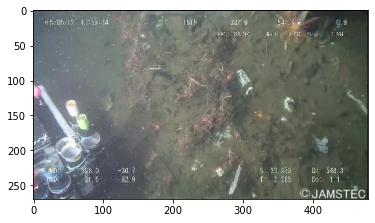

In [12]:
# function to show the ground truth bounding boxes and labels for any image in dataset

def display_groundtruth(filename, data): # data is the dataframe above
    temp = data[data.file_name == filename]
    category_ids = temp.category_id
    box_list = temp.bbox.values

    image = Image.open('dataset\\material_version\\val\\' + filename)
    #dataset\material_version\val\vid_000002_frame0000013.jpg
    draw = ImageDraw.Draw(image)
    
    for (xmin, ymin, width, height), label in zip(box_list, category_ids):
        xmax = xmin + width
        ymax = ymin + height
        
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='yellow')
        draw.text((xmin, ymin), text=str(label))
        
        print(xmin, ymin, width, height, xmax, ymax)
    
    return image

test_list = ['vid_000035_frame0000087.jpg']

for i,im in enumerate(test_list):
     plt.figure(i)
     plt.imshow(display_groundtruth(im, data))

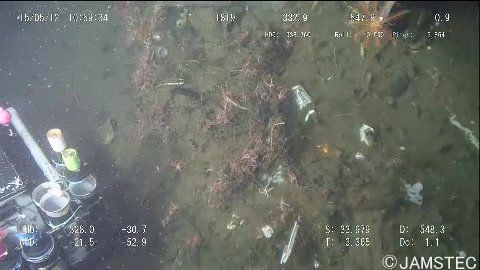

In [13]:
display_groundtruth('vid_000035_frame0000087.jpg', data)

# example of data point where bounding box is greater than image (affecting standardization step later) 

In [14]:
data[data.file_name == 'vid_000035_frame0000087.jpg']

,image_id,id,file_name,category_id,bbox,width,height


In [15]:
# construct Dataset class for pytorch

class UnderwaterTrashDataset(torch.utils.data.Dataset):
    '''
    Pytorch Dataset class for Underwater Trash Dataset (Trash_CAN 1.0)
    
    data_file_path := path to pickle file containing dataset (annotations and filenames to images)
    images_path := path to folder containing actual image files
    transforms := from references/detection/transforms.py (pytorch), helps with data transformation and augmentation
    '''
    
    def __init__(self, data_file_path, images_path, transforms=None):
        if data_file_path:
            self.data = pd.read_pickle(data_file_path)
        self.images_path = images_path
        self.transforms = transforms
    
    
    def __getitem__(self, idx):
        temp = data[data.image_id == idx+1]
        
        image = Image.open(os.path.join(self.images_path, temp.file_name.iloc[0])).convert("RGB")
        
        box_list = copy.deepcopy(list(temp.bbox))

        for box in box_list: # xmax = xmin + width, ymax = ymin + height
            box[2] = box[2] + box[0]
            box[3] = box[3] + box[1]
        
        box_list = torch.as_tensor(box_list, dtype=torch.float32)
        
        labels = torch.as_tensor(temp.category_id.values, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        area = (box_list[:, 3] - box_list[:, 1]) * (box_list[:, 2] - box_list[:,0])
        
        iscrowd = torch.zeros((len(box_list),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = box_list
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:
            image, target = self.transforms(image, target)
            
        return image, target

    
    def __len__(self):
        return self.data.image_id.nunique()
    
    
 

val and test dataset prep


In [16]:
# parse provided json file which contains annotations for each image

val_dict = {}

with open('dataset\material_version\instances_val_trashcan.json') as val:
    val_dict = json.load(val)

In [17]:
val_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [18]:
# compile the relevant data into a pickle file 
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(val_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(val_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
# data.to_pickle('UTD_val.pkl', protocol=4)
data.image_id = data.image_id - data.image_id[0]
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,9742,vid_000342_frame0000228.jpg,3,"[152.00196078431372, 216.00219298245614, 28.99...",480,270
1,1,9743,vid_000142_frame0000034.jpg,14,"[115.0047619047619, 89.01612903225806, 365.993...",480,270
2,1,9744,vid_000142_frame0000034.jpg,14,"[71.00196078431372, 70.00196078431372, 276.996...",480,270
3,2,9745,vid_000039_frame0000001.jpg,1,"[0.00196078431372549, 96.00242718446601, 131.9...",480,270
4,3,9746,vid_000234_frame0000001.jpg,16,"[160.00196078431372, 101.00196078431372, 145.9...",480,360
...,...,...,...,...,...,...,...
2590,1202,12332,vid_000102_frame0000006.jpg,5,"[329.0111111111111, 182.0084745762712, 102.985...",480,270
2591,1202,12333,vid_000102_frame0000006.jpg,6,"[377.0059523809524, 68.0111111111111, 32.99112...",480,270
2592,1202,12334,vid_000102_frame0000006.jpg,12,"[208.01612903225808, 112.0020325203252, 62.975...",480,270
2593,1203,12335,vid_000146_frame0000016.jpg,12,"[184.00196078431372, 187.00196078431372, 32.99...",480,270


In [19]:
data.category_id.nunique()

16

In [20]:
data.category_id.value_counts()

1     664
9     409
14    374
12    225
3     153
4     124
2     102
5      78
7      76
16     69
11     69
10     67
6      62
8      55
13     39
15     29
Name: category_id, dtype: int64

(array([851., 287.,  39.,  10.,   5.,   5.,   4.,   2.,   0.,   1.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

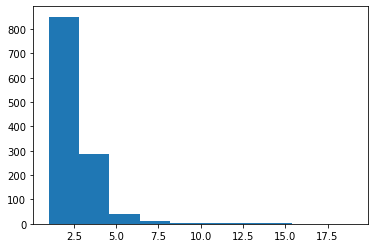

In [21]:
plt.hist(data.image_id.value_counts())

# most of the val dataset has 2 bounding boxes

In [22]:
len(data.image_id.value_counts())


1204

In [23]:
t = data.image_id.value_counts()
t[t == 2] 

552     2
550     2
506     2
496     2
727     2
       ..
419     2
988     2
338     2
475     2
1056    2
Name: image_id, Length: 343, dtype: int64

In [24]:
343/1204

0.28488372093023256

In [25]:
data[data['image_id'].map(data['image_id'].value_counts()) == 2].category_id.unique()

# we can take this ~30% of the val dataset and use it as test data (held out)
# all the images in this set have 2 bounding boxes (given)
# here we can verify that all the 16 categories are represented in this set

array([14,  1, 12,  3, 11,  4,  7,  9, 15, 16, 10,  2, 13,  6,  8,  5],
      dtype=int64)

In [26]:
test = data[data['image_id'].map(data['image_id'].value_counts()) == 2]
test

,image_id,id,file_name,category_id,bbox,width,height
1,1,9743,vid_000142_frame0000034.jpg,14,"[115.0047619047619, 89.01612903225806, 365.993...",480,270
2,1,9744,vid_000142_frame0000034.jpg,14,"[71.00196078431372, 70.00196078431372, 276.996...",480,270
5,4,9747,vid_000074_frame0000052.jpg,1,"[100.05, 0.00196078431372549, 379.95, 270.9960...",480,270
6,4,9748,vid_000074_frame0000052.jpg,12,"[163.00595238095238, 54.001960784313724, 24.99...",480,270
7,5,9749,vid_000153_frame0000013.jpg,3,"[312.0030487804878, 235.0026455026455, 13.9932...",480,360
...,...,...,...,...,...,...,...
2584,1198,12326,vid_000119_frame0000017.jpg,8,"[235.00196078431372, 160.00196078431372, 21.99...",480,270
2587,1201,12329,vid_000036_frame0000006.jpg,1,"[0.001968503937007874, 88.00196078431372, 215....",480,270
2588,1201,12330,vid_000036_frame0000006.jpg,14,"[148.00531914893617, 154.01162790697674, 55.97...",480,270
2593,1203,12335,vid_000146_frame0000016.jpg,12,"[184.00196078431372, 187.00196078431372, 32.99...",480,270


In [27]:
data = data[~data.index.isin(test.index)]

In [28]:

data.category_id.nunique()

16

In [29]:
test.category_id.nunique()

16

In [30]:
len(data)

1909

In [31]:
len(test)

686

In [32]:
data.image_id.nunique()

861

In [33]:
test.image_id.nunique()

343

In [34]:
861/6008


0.14330892143808255

In [35]:
(data.category_id - 1).unique()

array([ 2,  0, 15,  8, 11, 13,  6,  4,  7, 10,  9,  1, 14,  3, 12,  5],
      dtype=int64)

In [36]:
#data = data.reset_index(drop=True)
#data.image_id = data.index
data


,image_id,id,file_name,category_id,bbox,width,height
0,0,9742,vid_000342_frame0000228.jpg,3,"[152.00196078431372, 216.00219298245614, 28.99...",480,270
3,2,9745,vid_000039_frame0000001.jpg,1,"[0.00196078431372549, 96.00242718446601, 131.9...",480,270
4,3,9746,vid_000234_frame0000001.jpg,16,"[160.00196078431372, 101.00196078431372, 145.9...",480,360
9,6,9751,vid_000002_frame0000017.jpg,9,"[274.0019607843137, 183.00196078431372, 44.996...",480,270
10,7,9752,vid_000081_frame0000020.jpg,12,"[114.00196078431372, 73.00196078431372, 47.996...",480,270
...,...,...,...,...,...,...,...
2586,1200,12328,vid_000045_frame0000011.jpg,1,"[405.0019607843137, 230.00862068965517, 43.984...",480,270
2589,1202,12331,vid_000102_frame0000006.jpg,5,"[408.0019607843137, 198.00196078431372, 40.996...",480,270
2590,1202,12332,vid_000102_frame0000006.jpg,5,"[329.0111111111111, 182.0084745762712, 102.985...",480,270
2591,1202,12333,vid_000102_frame0000006.jpg,6,"[377.0059523809524, 68.0111111111111, 32.99112...",480,270


In [37]:
# groupby file_name and set index within each group
# this is to 0-index the image_id's while still keeping the same mapping from image_id/file_name and id

groups = data.groupby(['file_name'])
x = pd.DataFrame()

count = 0
for name, group in groups:
#     print(name)
    group.image_id = count
#     print(group.image_id)
    x = pd.concat([x, group])
    count += 1

In [38]:
x.image_id.value_counts()


147    19
149    14
143    14
457    13
301    12
       ..
322     1
323     1
324     1
325     1
860     1
Name: image_id, Length: 861, dtype: int64

In [39]:
x.file_name.sort_values()

431     vid_000002_frame0000013.jpg
862     vid_000002_frame0000014.jpg
377     vid_000002_frame0000015.jpg
1623    vid_000002_frame0000016.jpg
9       vid_000002_frame0000017.jpg
                   ...             
51      vid_000337_frame0000160.jpg
805     vid_000342_frame0000213.jpg
540     vid_000342_frame0000225.jpg
646     vid_000342_frame0000227.jpg
0       vid_000342_frame0000228.jpg
Name: file_name, Length: 1909, dtype: object

In [40]:
x[x.image_id == 457]

,image_id,id,file_name,category_id,bbox,width,height
1901,457,11643,vid_000090_frame0000051.jpg,14,"[66.00196078431372, 192.00196078431372, 73.996...",480,270
1902,457,11644,vid_000090_frame0000051.jpg,11,"[0.0020242914979757085, 0.004424778761061947, ...",480,270
1903,457,11645,vid_000090_frame0000051.jpg,14,"[0.00196078431372549, 0.00196078431372549, 345...",480,270
1904,457,11646,vid_000090_frame0000051.jpg,14,"[0.00196078431372549, 58.001960784313724, 335....",480,270
1905,457,11647,vid_000090_frame0000051.jpg,11,"[316.0019607843137, 45.001960784313724, 164.99...",480,270
1906,457,11648,vid_000090_frame0000051.jpg,4,"[48.001960784313724, 147.00196078431372, 30.99...",480,270
1907,457,11649,vid_000090_frame0000051.jpg,4,"[26.001960784313727, 130.00196078431372, 44.99...",480,270
1908,457,11650,vid_000090_frame0000051.jpg,4,"[208.00196078431372, 223.00196078431372, 58.99...",480,270
1909,457,11651,vid_000090_frame0000051.jpg,4,"[192.00196078431372, 65.00196078431372, 29.996...",480,270
1910,457,11652,vid_000090_frame0000051.jpg,4,"[428.0019607843137, 108.00196078431372, 43.996...",480,270


In [41]:
data[data.file_name == 'vid_000090_frame0000051.jpg']

,image_id,id,file_name,category_id,bbox,width,height
1901,879,11643,vid_000090_frame0000051.jpg,14,"[66.00196078431372, 192.00196078431372, 73.996...",480,270
1902,879,11644,vid_000090_frame0000051.jpg,11,"[0.0020242914979757085, 0.004424778761061947, ...",480,270
1903,879,11645,vid_000090_frame0000051.jpg,14,"[0.00196078431372549, 0.00196078431372549, 345...",480,270
1904,879,11646,vid_000090_frame0000051.jpg,14,"[0.00196078431372549, 58.001960784313724, 335....",480,270
1905,879,11647,vid_000090_frame0000051.jpg,11,"[316.0019607843137, 45.001960784313724, 164.99...",480,270
1906,879,11648,vid_000090_frame0000051.jpg,4,"[48.001960784313724, 147.00196078431372, 30.99...",480,270
1907,879,11649,vid_000090_frame0000051.jpg,4,"[26.001960784313727, 130.00196078431372, 44.99...",480,270
1908,879,11650,vid_000090_frame0000051.jpg,4,"[208.00196078431372, 223.00196078431372, 58.99...",480,270
1909,879,11651,vid_000090_frame0000051.jpg,4,"[192.00196078431372, 65.00196078431372, 29.996...",480,270
1910,879,11652,vid_000090_frame0000051.jpg,4,"[428.0019607843137, 108.00196078431372, 43.996...",480,270


In [42]:
data = x.reset_index(drop=True)
data

,image_id,id,file_name,category_id,bbox,width,height
0,0,10173,vid_000002_frame0000013.jpg,9,"[254.00196078431372, 81.00196078431372, 34.996...",480,270
1,1,10604,vid_000002_frame0000014.jpg,9,"[261.0019607843137, 101.00320512820512, 35.996...",480,270
2,2,10119,vid_000002_frame0000015.jpg,9,"[267.0019607843137, 137.00196078431372, 38.996...",480,270
3,3,11365,vid_000002_frame0000016.jpg,9,"[273.0019607843137, 164.00196078431372, 41.996...",480,270
4,4,9751,vid_000002_frame0000017.jpg,9,"[274.0019607843137, 183.00196078431372, 44.996...",480,270
...,...,...,...,...,...,...,...
1904,856,9793,vid_000337_frame0000160.jpg,3,"[263.0019607843137, 85.00196078431372, 25.9960...",480,270
1905,857,10547,vid_000342_frame0000213.jpg,3,"[192.00196078431372, 105.00196078431372, 46.99...",480,270
1906,858,10282,vid_000342_frame0000225.jpg,3,"[190.0, 176.00196078431372, 21.998039215686276...",480,270
1907,859,10388,vid_000342_frame0000227.jpg,3,"[163.00359712230215, 200.00387596899225, 30.99...",480,270


In [43]:
groups = test.groupby(['file_name'])
w = pd.DataFrame()

count = 0
for name, group in groups:
    group.image_id = count
    w = pd.concat([w, group])
    count += 1
       
test = w.reset_index(drop=True)


test

,image_id,id,file_name,category_id,bbox,width,height
0,0,12187,vid_000004_frame0000010.jpg,9,"[100.00196078431372, 155.5, 27.998039215686276...",480,270
1,0,12188,vid_000004_frame0000010.jpg,9,"[79.00196078431372, 141.00196078431372, 49.996...",480,270
2,1,11026,vid_000004_frame0000011.jpg,10,"[91.0054347826087, 172.00625, 27.9862318840579...",480,270
3,1,11027,vid_000004_frame0000011.jpg,16,"[79.00196078431372, 149.00196078431372, 60.996...",480,270
4,2,10006,vid_000004_frame0000012.jpg,10,"[96.00196078431372, 158.00196078431372, 54.996...",480,270
...,...,...,...,...,...,...,...
681,340,11763,vid_000340_frame0000029.jpg,3,"[241.00196078431372, 163.00196078431372, 22.99...",480,270
682,341,11138,vid_000342_frame0000265.jpg,3,"[169.00290697674419, 128.00196078431372, 35.98...",480,270
683,341,11139,vid_000342_frame0000265.jpg,7,"[240.00196078431372, 163.00196078431372, 26.99...",480,270
684,342,11781,vid_000342_frame0000266.jpg,3,"[161.00196078431372, 136.001968503937, 30.9957...",480,270


In [44]:
w.image_id.value_counts().isin([2]).all() # all the image ids are pairs which is what we expected

True

In [45]:
pd.__version__

'1.3.5'

In [46]:
data.to_pickle('UTD_val.pkl')
test.to_pickle('UTD_test.pkl')

In [51]:
data.category_id.nunique()

16

In [47]:
val = pd.read_pickle('UTD_val.pkl')
val

,image_id,id,file_name,category_id,bbox,width,height
0,0,10173,vid_000002_frame0000013.jpg,9,"[254.00196078431372, 81.00196078431372, 34.996...",480,270
1,1,10604,vid_000002_frame0000014.jpg,9,"[261.0019607843137, 101.00320512820512, 35.996...",480,270
2,2,10119,vid_000002_frame0000015.jpg,9,"[267.0019607843137, 137.00196078431372, 38.996...",480,270
3,3,11365,vid_000002_frame0000016.jpg,9,"[273.0019607843137, 164.00196078431372, 41.996...",480,270
4,4,9751,vid_000002_frame0000017.jpg,9,"[274.0019607843137, 183.00196078431372, 44.996...",480,270
...,...,...,...,...,...,...,...
1904,856,9793,vid_000337_frame0000160.jpg,3,"[263.0019607843137, 85.00196078431372, 25.9960...",480,270
1905,857,10547,vid_000342_frame0000213.jpg,3,"[192.00196078431372, 105.00196078431372, 46.99...",480,270
1906,858,10282,vid_000342_frame0000225.jpg,3,"[190.0, 176.00196078431372, 21.998039215686276...",480,270
1907,859,10388,vid_000342_frame0000227.jpg,3,"[163.00359712230215, 200.00387596899225, 30.99...",480,270


58.001960784313724 83.00196078431372 65.99607843137255 186.99607843137255 123.99803921568628 269.9980392156863
58.001960784313724 83.00196078431372 65.99607843137255 186.99607843137255 123.99803921568628 269.9980392156863
233.00196078431372 1.0019607843137255 247.99607843137255 252.99607843137255 480.9980392156863 253.99803921568628
72.00196078431372 102.00196078431372 203.99607843137255 118.99607843137255 275.9980392156863 220.99803921568628


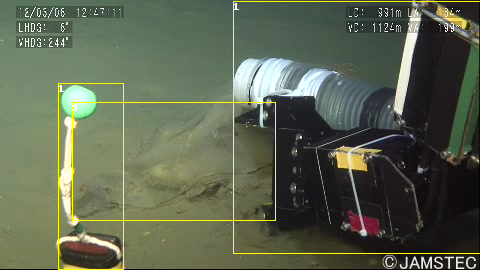

In [48]:
display_groundtruth('vid_000143_frame0000013.jpg', val)


In [49]:
val[val.duplicated(['image_id'])]

,image_id,id,file_name,category_id,bbox,width,height
35,34,11462,vid_000021_frame0000001.jpg,1,"[445.0019607843137, 221.00196078431372, 33.996...",480,270
36,34,11463,vid_000021_frame0000001.jpg,4,"[120.0028409090909, 252.00280898876406, 18.993...",480,270
38,35,11315,vid_000021_frame0000018.jpg,1,"[373.0019607843137, 240.00196078431372, 35.996...",480,270
39,35,11316,vid_000021_frame0000018.jpg,1,"[444.0019607843137, 221.00196078431372, 35.996...",480,270
41,36,11858,vid_000021_frame0000019.jpg,1,"[373.0019607843137, 241.00196078431372, 34.996...",480,270
...,...,...,...,...,...,...,...
1899,855,11210,vid_000329_frame0000016.jpg,3,"[8.001960784313725, 148.00196078431372, 57.996...",480,270
1900,855,11211,vid_000329_frame0000016.jpg,1,"[146.00196078431372, 195.00196078431372, 302.9...",480,270
1902,856,9791,vid_000337_frame0000160.jpg,3,"[26.002512562814072, 233.00196078431372, 68.99...",480,270
1903,856,9792,vid_000337_frame0000160.jpg,3,"[196.00196078431372, 64.00196078431372, 22.996...",480,270


In [52]:
val.category_id.nunique()

16